<a href="https://colab.research.google.com/github/amadousysada/scoring-model/blob/master/03_modelisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="text-align:center; font-size:3.3em; color:#AD7D67; line-height:5rem; font-style:italic; font-weight:700;">
    Projet N°4 : <br>
    Implémentation d'un modèle de scoring </p>
<p style="text-align:center; font-size:2.8em; color:#9EBEB8; line-height:4rem; font-style:italic; font-weight:700;">
    IV - Modélisation
</p>

# 1. Préparation des données

In [1]:
# Forcer l'installation de la version 1.5.2 pour palier à une regression de scikit-learn qui impacte la librairie xgboost
# Line vers l'issue https://github.com/scikit-learn/scikit-learn/issues/30479

!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 90.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import warnings
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, auc, make_scorer, confusion_matrix, fbeta_score
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
folder_path = "data/" # A ajuster selon le chemin où se trouve vos cvs.

In [4]:
X_train = pd.read_csv(f"{folder_path}final_cleaned_app_train.csv")
X_test = pd.read_csv(f"{folder_path}final_cleaned_app_test.csv")

In [5]:
X_train.drop(columns=['SK_ID_CURR'], inplace=True)
X_test.drop(columns=['SK_ID_CURR'], inplace=True)

In [6]:
X_train['TARGET'].isna().sum()

0

In [7]:
# Séparation de l'ensemble X_train en 2 sous-ensembles
y = X_train['TARGET']
X_train.drop(labels='TARGET', axis=1, inplace=True)

X_Xtrain, X_valid, y_train, y_valid = train_test_split(X_train, y, stratify=y, test_size=0.3, random_state=42)
X_Xtrain.shape, X_valid.shape

((215257, 15), (92254, 15))

TARGET
0    282686
1     24825
Name: count, dtype: int64


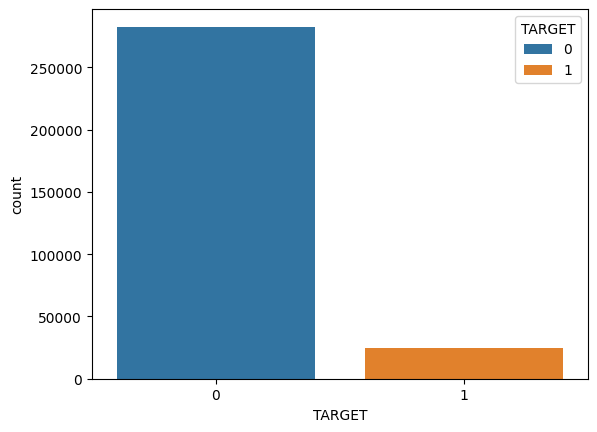

In [8]:
print(y.value_counts())
fig, ax = plt.subplots()
sns.countplot(data=y.to_frame(), x='TARGET', ax=ax, hue='TARGET')
xticks = ax.xaxis.get_ticks_position()
ax.xaxis.set_ticks([0, 1])
plt.show()

In [9]:
# Le ratio du desequilibre
print(f"imbalance_ratio = {24825 / 282686:.2%}")

imbalance_ratio = 8.78%


In [10]:
# Fonction pour calculer le coût métier
def business_cost(y_true, y_pred):
    """
    Calcule le coût métier en fonction des faux négatifs et faux positifs.

    Paramètres :
    y_true (array-like) : Les vraies étiquettes (0 ou 1).
    y_pred (array-like) : Les prédictions du modèle (0 ou 1).

    Retourne :
    float : Le coût métier basé sur 10 * FN + FP.
    """
    # Matrice de confusion : [[TN, FP], [FN, TP]]
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calcul du coût métier
    cost = 10 * fn + fp
    return cost

# Scorer pour le coût métier
business_scorer = make_scorer(business_cost, greater_is_better=False)

# 2. Dummy Classifier

Metric accuray: 0.9192663732737876
Metric roc_auc: 0.5
Metric f1: 0.0
Metric Metier: 74480
Matrice de confusion:
[[84806     0]
 [ 7448     0]]


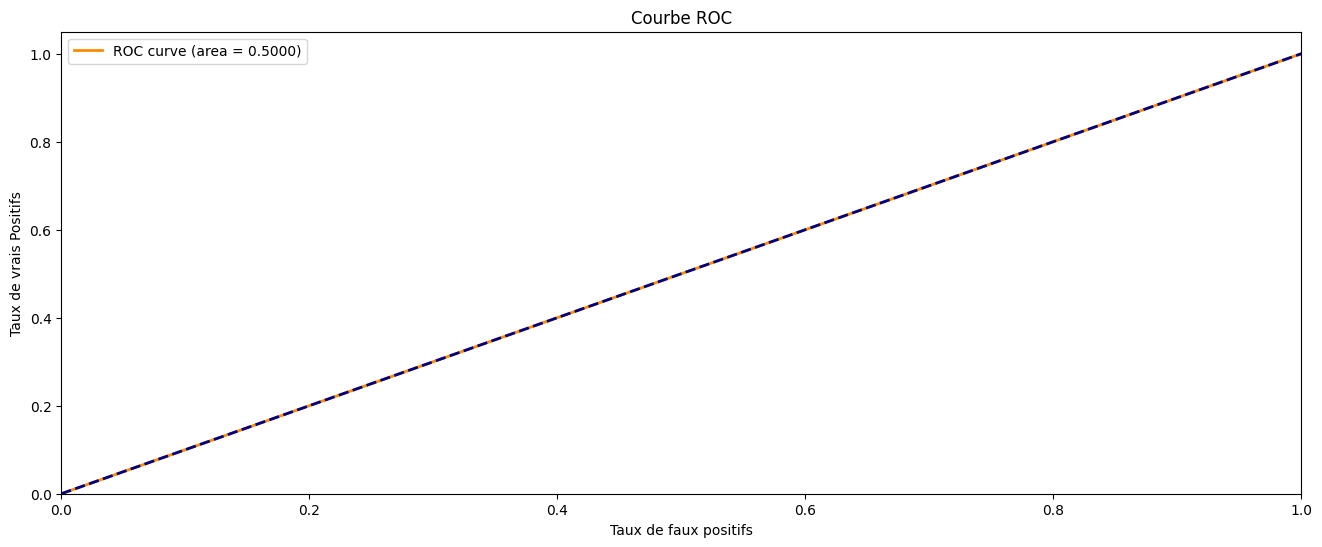

In [45]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)

dummy_clf.fit(X_Xtrain, y_train)

# Prédictions
y_pred = dummy_clf.predict(X_valid)
y_prob = dummy_clf.predict_proba(X_valid)[:, 1]

# Calcul des métriques
accuracy = accuracy_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_prob)
f1 = f1_score(y_valid, y_pred)

# Metric metier
cost = business_cost(y_valid, y_pred)

conf_matrix = confusion_matrix(y_valid, y_pred)

print(f"Metric accuray: {accuracy}")
print(f"Metric roc_auc: {roc_auc}")
print(f"Metric f1: {f1}")
print(f"Metric Metier: {cost}")

print(f"Matrice de confusion:\n{conf_matrix}")

fpr, tpr, _ = roc_curve(y_valid, y_prob)
roc_auc = auc(fpr, tpr)

fig = plt.figure(figsize=(16, 6))

# Visualiser la courbe ROC AUC
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais Positifs')
plt.title('Courbe ROC')
plt.legend(loc="upper left")
plt.show()

In [78]:

models = {
    "Logistic Regression": LogisticRegression(random_state=42, n_jobs=-1),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, n_jobs=-1),
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1),
}

# Grilles d'hyperparamètres
param_grids = {
    "Logistic Regression": {
        "model__C": [0.01, 0.1, 1, 10],
        "model__penalty": ["l2"],
        "model__class_weight": [None, "balanced"]
    },
    "Random Forest": {
        "model__n_estimators": [10, 100],
        "model__max_depth": [3, 6],
        "model__class_weight": [None, "balanced"]
    },
    "XGBoost": {
        "model__n_estimators": [10, 100, 200],
        "model__max_depth": [3, 6],
        "model__scale_pos_weight": [1, 10]
    },
    "LightGBM": {
        "model__n_estimators": [200, 300],
        "model__learning_rate": [0.15, 0.2, 0.25],
        "model__max_depth": [6, 10],
        "model__scale_pos_weight": [1, 5]
    }
}


In [13]:
# Résultats des modèles
model_results = {}
import os
if os.path.exists(f"{folder_path}grid_search_results.pkl"):
    with open(f"{folder_path}grid_search_results.pkl", "rb") as f:
        model_results = pickle.load(f)

In [14]:
model_results

{}

In [15]:
# Un decorateur pour tracker le temps d'execution des modéles
def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Temps d'entrainement du modèle {kwargs.get('model_name')}: {execution_time:.2f} secondes")
        return result
    return wrapper

In [16]:
@timer
def evaluate_model(model_name, X_train, y_train, X_valid, y_valid, force=True):
  """
  Entrainer un modèle, prédire sur l'ensemble de validation et évaluer les performances.

  Paramètres :
  model_name : Le nom modèle à entraîner.
  X_train, y_train : Les données d'entraînement.
  X_valid, y_valid : Les données de validation.

  Retourne :
  obj: Les résultats de l'évaluation du modèle.
  """
  print(f"Évaluation du modèle : {model_name}")

  # Pipeline avec SMOTE
  pipeline = ImbPipeline(steps=[
      ("imputer", SimpleImputer(strategy="median")),
      ("scaler", StandardScaler()),
      ("smote", SMOTE(random_state=42)),  # SMOTE pour rééquilibrer les classes
      ("model", models[model_name])
  ])


  # GridSearchCV
  grid_search = GridSearchCV(
      estimator=pipeline,
      param_grid=param_grids[model_name],
      scoring={
          "business_score": business_scorer,
          "AUC": "roc_auc",
          "F1": "f1",
          "Accuracy": "accuracy",
          "Recall": "recall",
          "Precision": "precision",
          "F2": make_scorer(fbeta_score, beta=2)
      },
      refit="business_score",  # Optimisation basée sur le score métier
      cv=5,
      verbose=1,
      return_train_score=True
  )

  # Entraînement
  if force or model_name not in model_results:
    grid_search.fit(X_train, y_train)
    model_results[model_name] = grid_search
  else:
    grid_search = model_results[model_name]

  # Sauvegarder les resultats, pour eviter plus tard le coùt de calcul
  with open(f"{folder_path}grid_search_results.pkl", "wb") as f:
    pickle.dump(grid_search, f)

  y_pred = grid_search.predict(X_valid)
  y_prob = grid_search.predict_proba(X_valid)[:, 1]

  # Résultats
  print("Meilleurs paramètres :", grid_search.best_params_)
  print("Meilleur score métier :", grid_search.best_score_)
  print("Matrice de confusion :", confusion_matrix(y_valid, y_pred))

  fpr, tpr, _ = roc_curve(y_valid, y_prob)
  roc_auc = auc(fpr, tpr)

  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6))

  # Récupérer les scores pour chaque combinaison d'hyperparamètres
  scores = -grid_search.cv_results_['mean_test_business_score']
  params = grid_search.cv_results_['params']

  # Visualiser notre score metier
  ax0.plot(range(len(scores)), scores, marker='o')
  ax0.set_title("Score métier pour chaque combinaison d'hyperparamètres")
  ax0.set_xlabel("Index de la combinaison d'hyperparamètres")
  ax0.set_ylabel("Score métier (plus bas est meilleur)")
  ax0.set_xticks(range(len(scores)), labels=[str(p) for p in params], rotation=90)
  ax0.grid(True)

  # Visualiser la courbe ROC AUC
  ax1.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
  ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  ax1.set_xlim([0.0, 1.0])
  ax1.set_ylim([0.0, 1.05])
  ax1.set_xlabel('Taux de faux positifs')
  ax1.set_ylabel('Taux de vrais Positifs')
  ax1.set_title('Courbe ROC')
  ax1.legend(loc="upper left")
  plt.show()

  print("-" * 50)
  return grid_search

# 3. RandomForest

Évaluation du modèle : Random Forest
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Meilleurs paramètres : {'model__class_weight': None, 'model__max_depth': 6, 'model__n_estimators': 100}
Meilleur score métier : -26321.2
Matrice de confusion : [[57248 27558]
 [ 2813  4635]]


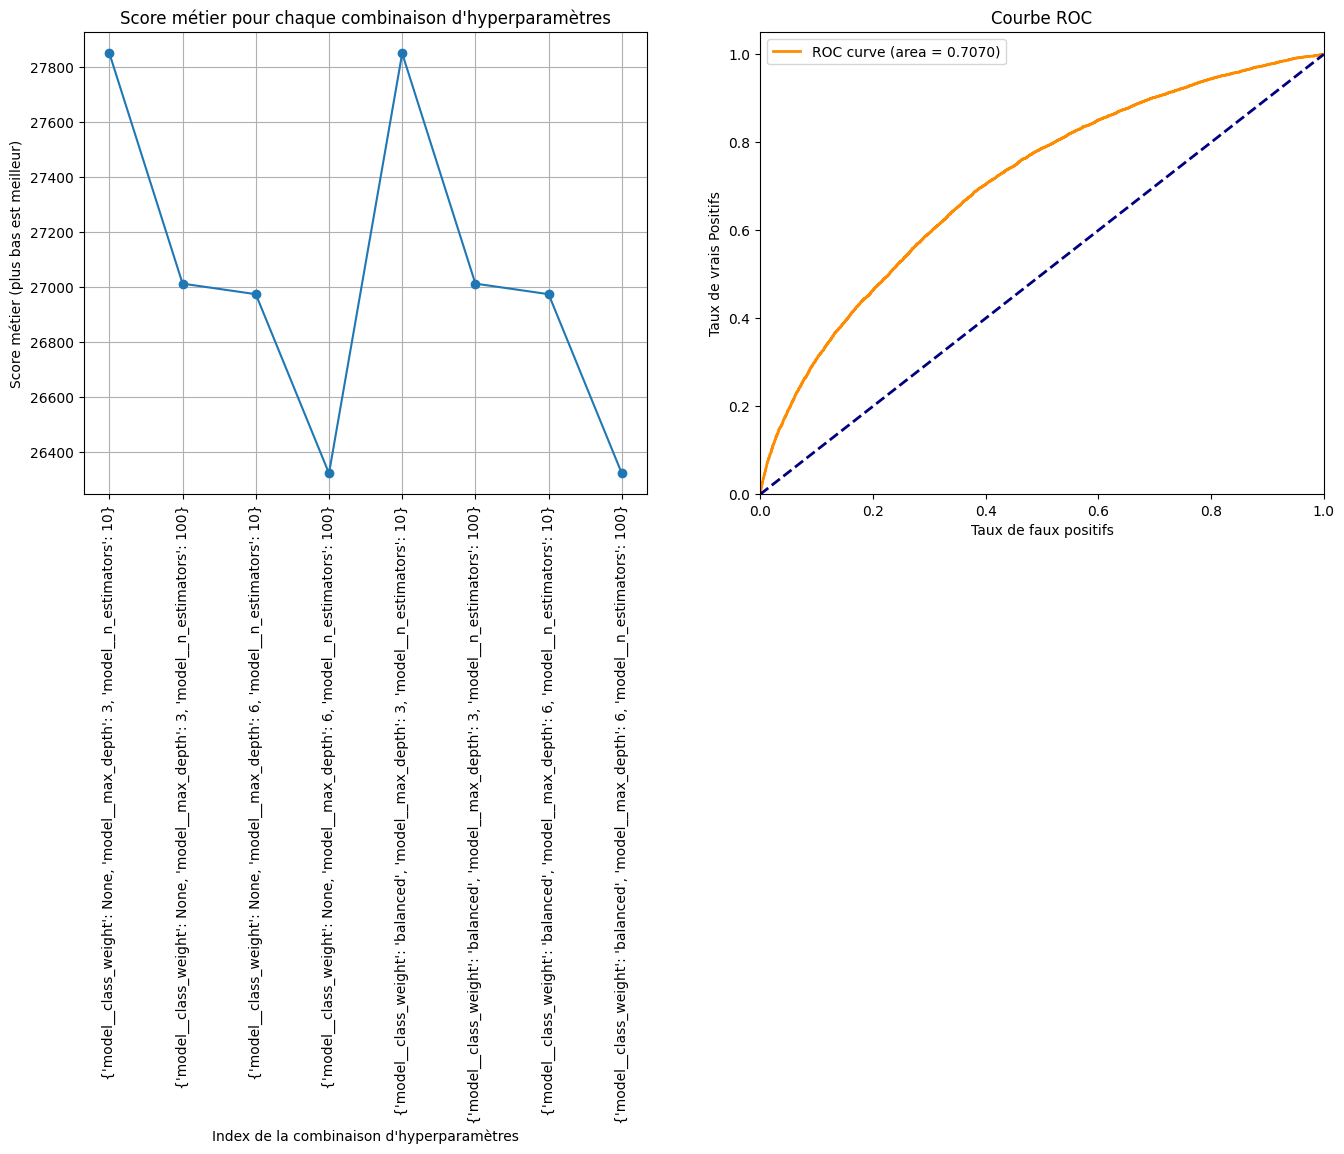

--------------------------------------------------
Temps d'entrainement du modèle Random Forest: 436.50 secondes


In [20]:
res = evaluate_model(model_name='Random Forest', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=False)

# 4. Logistic Regression

Évaluation du modèle : Logistic Regression
Meilleurs paramètres : {'model__C': 10, 'model__class_weight': None, 'model__penalty': 'l2'}
Meilleur score métier : -24649.8
Matrice de confusion : [[57789 27017]
 [ 2534  4914]]


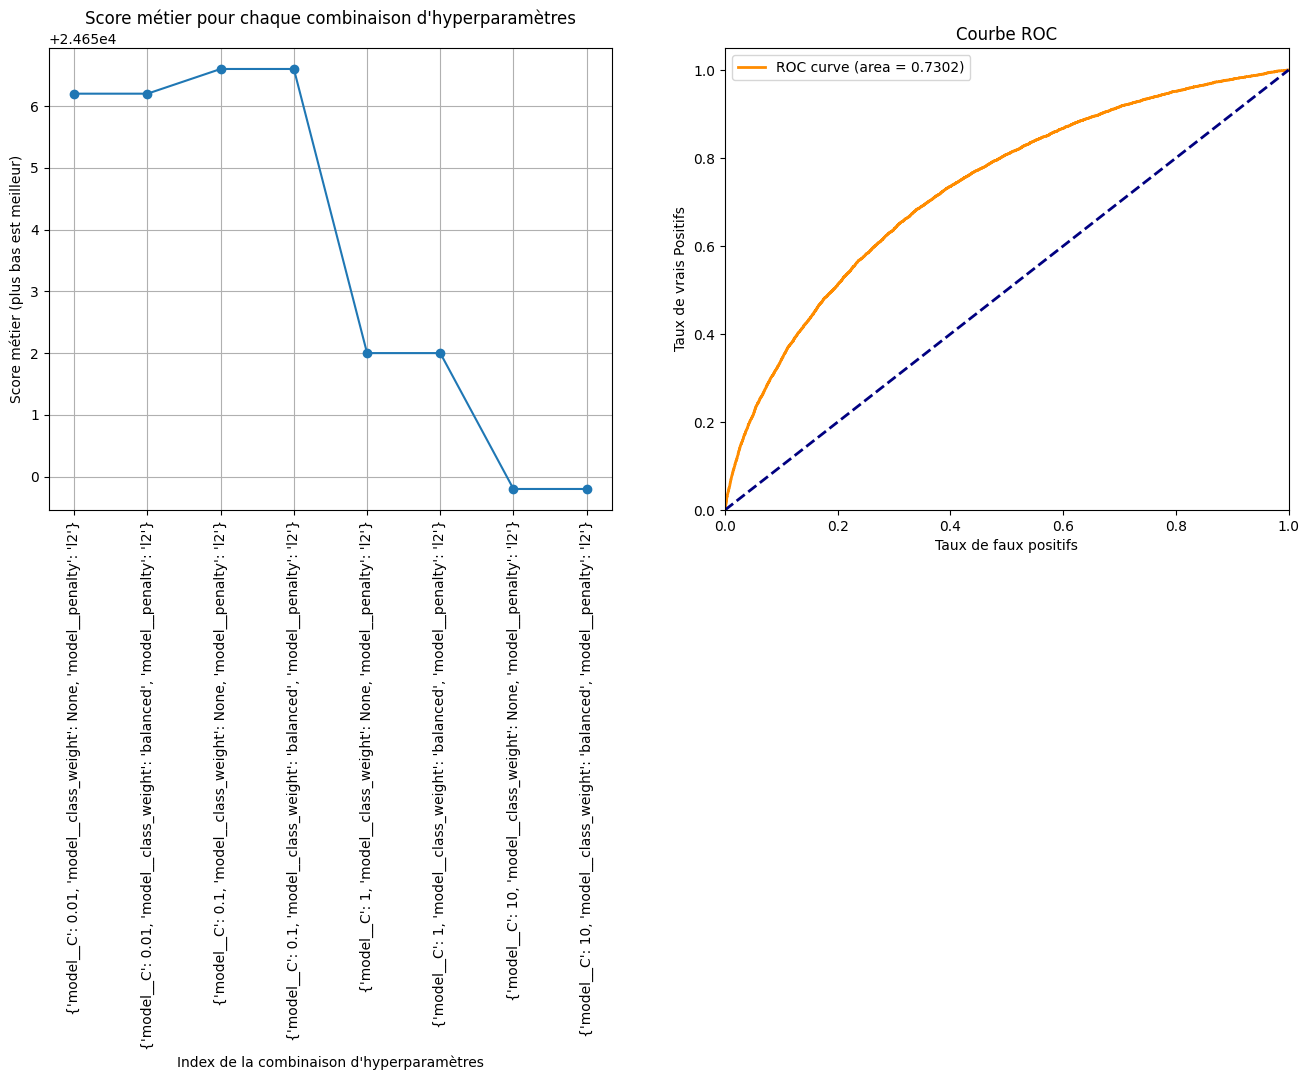

--------------------------------------------------
Temps d'entrainement du modèle Logistic Regression: 0.65 secondes


In [26]:
res = evaluate_model(model_name='Logistic Regression', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=False)

In [27]:
res.cv_results_

{'mean_fit_time': array([6.26913576, 6.33256335, 6.28558216, 6.27297797, 6.15140076,
        6.23915577, 6.18200059, 6.18215656]),
 'std_fit_time': array([0.13441248, 0.0948704 , 0.03907582, 0.08700369, 0.09012514,
        0.05712172, 0.07515215, 0.05346269]),
 'mean_score_time': array([0.2241262 , 0.22657242, 0.22934608, 0.22870021, 0.22408004,
        0.24253001, 0.22198777, 0.24354124]),
 'std_score_time': array([0.0048927 , 0.00455437, 0.00273704, 0.00426909, 0.00365077,
        0.03599764, 0.00269779, 0.02789098]),
 'param_model__C': masked_array(data=[0.01, 0.01, 0.1, 0.1, 1.0, 1.0, 10.0, 10.0],
              mask=[False, False, False, False, False, False, False, False],
        fill_value=1e+20),
 'param_model__class_weight': masked_array(data=[None, 'balanced', None, 'balanced', None, 'balanced',
                    None, 'balanced'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_model__p

# 5. LightGBM

Évaluation du modèle : LightGBM
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Meilleurs paramètres : {'model__learning_rate': 0.2, 'model__max_depth': 6, 'model__n_estimators': 200, 'model__scale_pos_weight': 5}
Meilleur score métier : -25547.0
Matrice de confusion : [[64612 20194]
 [ 3398  4050]]


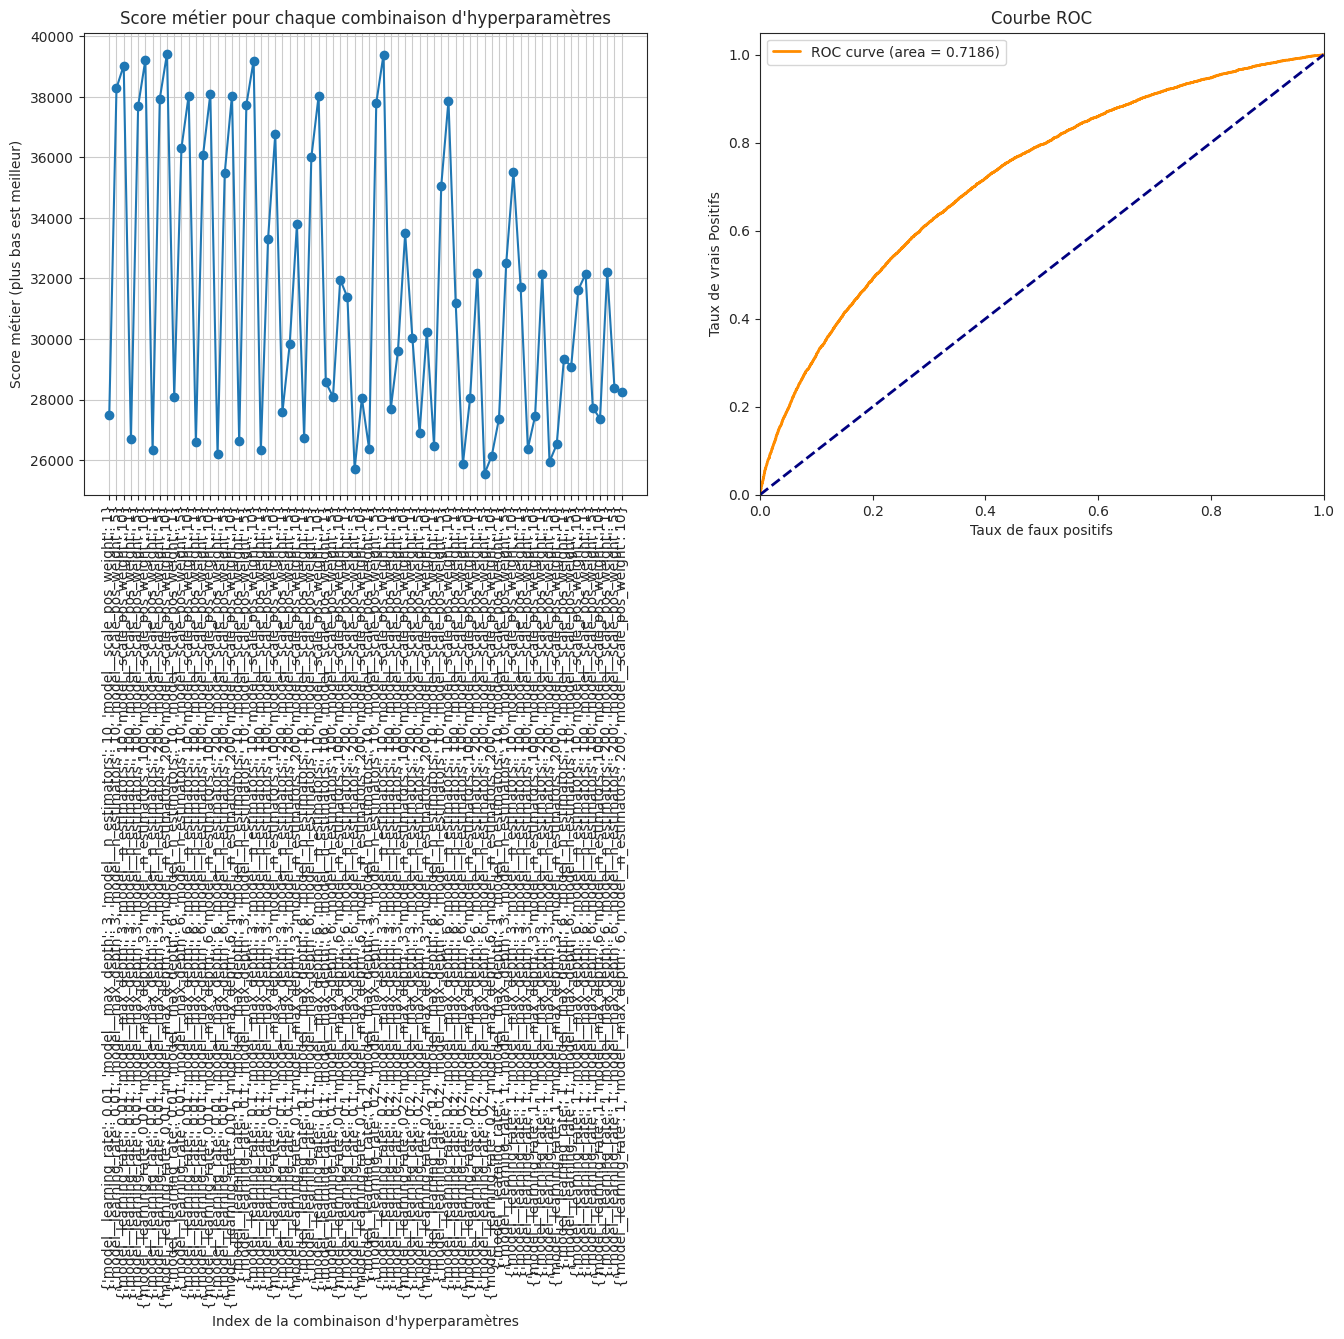

--------------------------------------------------
Temps d'entrainement du modèle LightGBM: 2491.98 secondes


In [79]:
warnings.simplefilter("ignore", FutureWarning)
res = evaluate_model(model_name='LightGBM', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=True)

# 6. XGBoost

Évaluation du modèle : XGBoost
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Meilleurs paramètres : {'model__max_depth': 3, 'model__n_estimators': 10, 'model__scale_pos_weight': 1}
Meilleur score métier : -26175.0
Matrice de confusion : [[59276 25530]
 [ 3163  4285]]


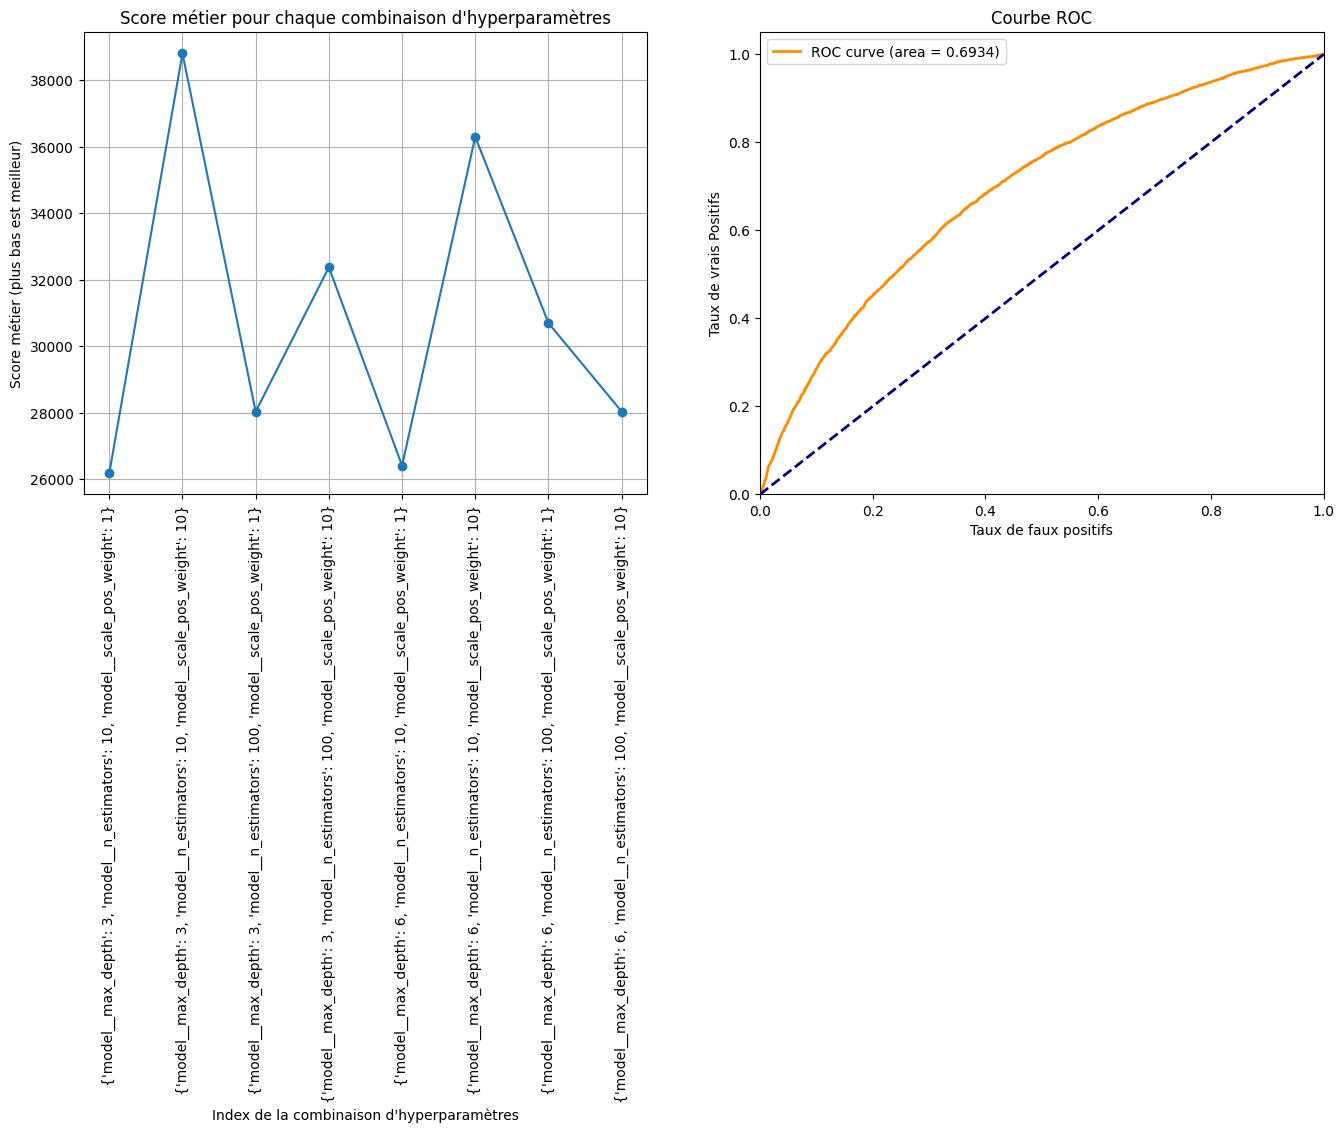

--------------------------------------------------
Temps d'entrainement du modèle XGBoost: 251.65 secondes


In [29]:
warnings.simplefilter("ignore", UserWarning)
res = evaluate_model(model_name='XGBoost', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=True)

In [76]:
metrics = [
    'business_score',
    'AUC',
    'F1',
    'Accuracy',
    'Recall',
    'Precision',
    'F2'
]

cv_results = {}
for key, grid_search in model_results.items():
    results = grid_search.cv_results_
    t = {}
    for metric in metrics:
      score = f"{results[f'mean_test_{metric}'][grid_search.best_index_]:.4f}"
      t[metric] = score
    cv_results[key] = t

metrics_df = pd.DataFrame(cv_results)
metrics_df.T

,business_score,AUC,F1,Accuracy,Recall,Precision,F2
Random Forest,-26321.2000,0.7025,0.2304,0.6681,0.6154,0.1418,0.3688
Logistic Regression,-24649.8000,0.7262,0.2474,0.6787,0.6542,0.1525,0.3946
LightGBM,-26317.8000,0.6966,0.2365,0.7076,0.5611,0.1499,0.3622
XGBoost,-26175.0000,0.7016,0.2344,0.6859,0.5955,0.1459,0.3684
